# LT8306
## 1. Select the Transformer Turns Ratio

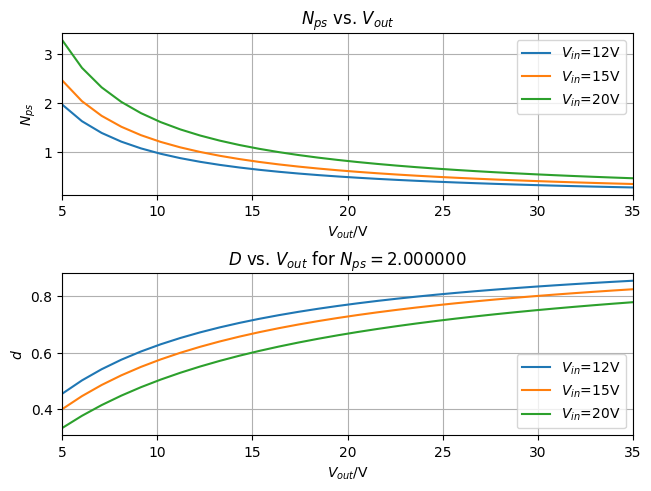

In [144]:
import numpy as np
import matplotlib.pyplot as plt

v_in = np.array([12, 15, 20]) # input voltage between 15V to 20V
v_out = np.linspace(5,35,30)
d_max = 0.45 # duty cycle, typically between 0.45 to 0.65
v_f = 0; # forward voltage (diode) --> set to zero, since LT8309 shall be used

n_ps = np.zeros((len(v_in), len(v_out)))
d = np.zeros((len(v_in), len(v_out)))

# calculate n_ps for different v_in and v_out
for i in range(len(v_in)):
    for j in range(len(v_out)):
        n_ps[i,j] = d_max * v_in[i] / ((1 - d_max) * (v_out[j] + v_f)) # primary to secondary winding ratio

# select n_ps = 1.5 for design (750311590)
n_ps_design = 2

# calucate duty cycle for fixed n_ps value
for i in range(len(v_in)):
    for j in range(len(v_out)):
        d[i,j] = ((v_out[j] + v_f)*n_ps_design)/(v_in[i] + (v_out[j] + v_f) * n_ps_design)
      
fig, ax = plt.subplots(2, 1, constrained_layout=True) # create figure

for i in range(len(v_in)):
    ax[0].plot(v_out, n_ps[i, :])
    ax[1].plot(v_out, d[i, :])

# plots
ax[0].set_title('$N_{ps}$ vs. $V_{out}$')
ax[0].legend(['$V_{in}$=12V', '$V_{in}$=15V', '$V_{in}$=20V'])
ax[0].set_xlabel('$V_{out}$/V')
ax[0].set_ylabel('$N_{ps}$')
ax[0].set_xlim(np.min(v_out),np.max(v_out))
ax[0].grid(True)

ax[1].set_title('$D$ vs. $V_{out}$ for $N_{ps} = %f$' % n_ps_design)
ax[1].legend(['$V_{in}$=12V', '$V_{in}$=15V', '$V_{in}$=20V'])
ax[1].set_xlabel('$V_{out}$/V')
ax[1].set_ylabel('$d$')
ax[1].set_xlim(np.min(v_out),np.max(v_out))
ax[1].grid(True)

## 2. Calculate $R_{sense}$ Resistor

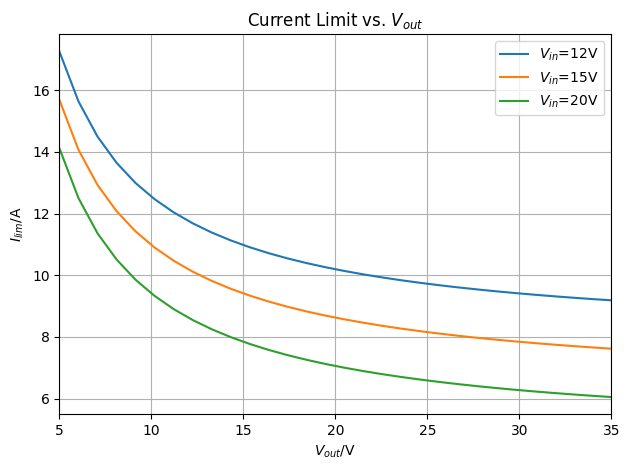

0.005277777777777778


In [9]:
pwr_max = 40 # maximum output power
eta = 0.85 # efficiency

i_lim = np.zeros((len(v_in), len(v_out)))

for i in range(len(v_in)):
    for j in range(len(v_out)):
        i_lim[i,j] = (2 * pwr_max / v_out[j]) / (eta * (1 - d[i,j]) * n_ps_design)

    plt.plot(v_out, i_lim[i,:])

plt.xlabel('$V_{out}$/V')
plt.ylabel('$I_{lim}$/A')
plt.title('Current Limit vs. $V_{out}$')
plt.legend(['$V_{in}$=12V', '$V_{in}$=15V', '$V_{in}$=20V'])
plt.grid(True)
plt.xlim(np.min(v_out),np.max(v_out))
plt.tight_layout()
plt.show()

i_lim_design = 18
r_sense = 95e-3 / i_lim_design

print(r_sense)

## 3. Calculate min. pri. Inductance

In [10]:
v_in_max = 20; # maximum input voltage
v_out_max = 35; # output voltage
v_f = 0.0; # forward voltage (diode) --> set to zero, since LT8309 shall be used
v_sense = 17e-3
r_sense_design = 0.002
t_demag = 440e-9; # minimum demagnetizing time
t_on = 200e-9; # minimum switch on-time

l_pri = ((v_out_max + v_f) * r_sense_design * t_demag * n_ps_design) / v_sense # minimum primary inductance 
print(l_pri)

l_pri = (v_in_max * r_sense * t_on) / v_sense
print(l_pri)

3.623529411764706e-06
1.241830065359477e-06


# 4. Select the Feedback Resistor

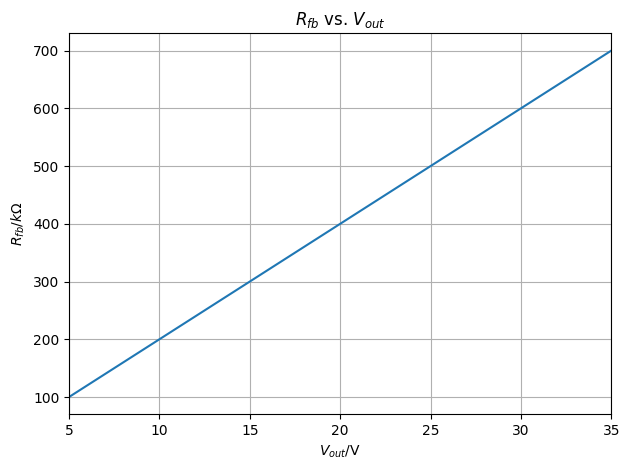

In [11]:
r_fb = n_ps_design * (v_out + v_f) / 100e-6

plt.plot(v_out, r_fb / 1e3)

plt.xlabel('$V_{out}$/V')
plt.ylabel('$R_{fb}/k\Omega$')
plt.title('$R_{fb}$ vs. $V_{out}$')
plt.xlim(np.min(v_out),np.max(v_out))
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Calculate Switching Frequency

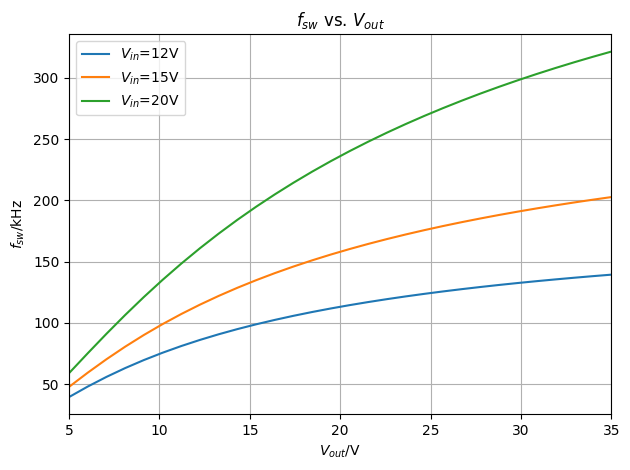

In [12]:
l_pri_design = 8e-6

f_sw = np.zeros((len(v_in), len(v_out)))

for i in range(len(v_in)):
    for j in range(len(v_out)):
        f_sw[i,j] = 1 / ( (l_pri_design * i_lim[i,j]) / v_in[i] + (l_pri_design * i_lim[i,j]) / (n_ps_design * (v_out[j] + v_f)))

    plt.plot(v_out, f_sw[i,:] / 1e3)

plt.xlabel('$V_{out}$/V')
plt.ylabel('$f_{sw}$/kHz')
plt.title('$f_{sw}$ vs. $V_{out}$')
plt.legend(['$V_{in}$=12V', '$V_{in}$=15V', '$V_{in}$=20V'])
plt.grid(True)
plt.xlim(np.min(v_out),np.max(v_out))
plt.tight_layout()
plt.show()

# $V_{out}$ Adjustment

The output voltage can be calculated by $V_{out} = V_{FB} \cdot (1 + R_1 / R_2 + R_1 / R_3) - V_{REF} \cdot R_1 / R_3$. 
The formula can be split into two parts, one for the coarse voltage tuning and one for the fine one. 

If you do so, you see, that $\Delta V_{out} = V_{FB} \cdot R_1/R_3 \cdot (1-x)$ where $x = V_{REF}/V_{FB}$. $\Delta V_{out}$ is always a negative value, since $V_{REF}$ must be greater than $V_{FB}$. This is the part for the "fine" tuning.

If you calculate range $\Delta\Delta V_{out}$ in which the output voltage can be adjusted, you get: $\Delta\Delta V_{out} = V_{FB} \cdot (1-x)\cdot R_1 \cdot \left(\frac{1}{R_{3,min}} - \frac{1}{R_{3,max}}\right)$

When you take this equation, insert a series resistor $R_s$ into $R_3$ you get: $\frac{\Delta\Delta V_{out}}{V_{FB} \cdot (1-x)\cdot R_1} = \frac{R_{3,max} - R_{3,min}}{R_{3,max} \cdot R_{3,min} + R_s \cdot (R_{3,max} + R_{3,min}) + R_s^2}$.

For $R_s$ you get: 

$R_s = -\frac{R_{3,max} + R_{3,min}}{2} \pm \sqrt{ \left(\frac{R_{3,max} + R_{3,min}}{2}\right)^2 - R_{3,max} \cdot R_{3,min} + \frac{V_{FB} \cdot (1-x)\cdot R_1}{\Delta\Delta V_{out}} \cdot \left(R_{3,max} - R_{3,min} \right)}$

To calculate the network correctly the following steps need to be done:

1. set $R_1$, consider the $I_{FB}$ input current (50nA in this case)
2. define $\Delta\Delta V_{out}$
3. solve the equation above
2. calculate the "basic" voltage divider without all $R_3$- dependent terms to fit your coarse voltage tuning


In [229]:
v_fb = 1
v_ref = 2
x = v_ref / v_fb

dd_v_out = -1.28

r_1 = 100e3
r_3_min = 100e3/1023
r_3_max = 100e3

# solve for r_s
p = (r_3_max + r_3_min)
q = (r_3_max * r_3_min) - ((r_3_max - r_3_min) * v_fb * (1 - x) * r_1) / dd_v_out

r_s = - p/2 + np.sqrt( np.power(p/2,2) - q )

print(r_s)

51439.93116752393


In [236]:
v_out = 0.1
v_fb = 1
v_ref = 2

x = v_ref / v_fb

r_1 = 100e3
r_2 = 100e3
r_3 = 51.4e3 + 100e3/1023*1022

v_out = v_fb * (1 + r_1 / r_2 + r_1 / r_3) - v_ref * r_1 / r_3

print(v_out)


1.3390712885590204


# "Worst" Voltage resolution

$\frac{\Delta V_{out,desired}}{V_{FB} \cdot R_1} = \frac{3 \cdot R_{step}}{R_s^2 + 3 \cdot R_s \cdot R_{step} + 2 \cdot R_{step}^2}$

In [257]:
r_step = 100e3/1023

sm_voltage_res = v_fb * r_1 * (1 - x) * r_step / (np.power(r_s, 2) + 3 * r_s * r_step + 2 * np.power(r_step, 2))

print(sm_voltage_res)

desired_res = -5e-3

r_s = 52e3

r_1_des = desired_res/(v_fb * (1 - x) * r_step / (np.power(r_s, 2) + 3 * r_s * r_step + 2 * np.power(r_step, 2)))

print(r_1_des)

-0.0037367217223617448
139090.57751710658
